In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob #glob is a python version of running the UNIX ls command. Comes in handy for finding files
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.cadc import Cadc #This is the import of specifc archive of Astroquery

## Reading Binary Tables with astropy

Reading into binary tables that are saved to FITS format works the same as it does for images, but when you inspect the HDU extensions beyond the PrimaryHDU, you will see that the format of the data *Type* says BinTableHDU.

In [3]:
#Locate a specific file
#NOTE: glob returns a Python list
file = glob.glob('./spectraDR/legac_M10_187035_v2.0.fits')
print(file)

['./spectraDR/legac_M10_187035_v2.0.fits']


In [4]:
#Read in the fits file
hdulist = fits.open(file[0]) #Have to select 0-th extension of the list!
print(hdulist.info())

Filename: ./spectraDR/legac_M10_187035_v2.0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     131   ()      
  1  PHASE3SPECTRA    1 BinTableHDU     46   1R x 4C   [6166E, 6166E, 6166E, 6166I]   
None


You can access the data in the BinTableHDU extension of the file using the data attribute on the respective extension of the HDUList. The data is then converted into a numpy record whose properties you can explore. The most useful will be seeing column names and definitions in the table. You can then access data from each column by names in allegory to dictionary/Pandas indexing.

In [5]:
data0 = hdulist[1].data


In [6]:
print(data0.columns)

ColDefs(
    name = 'WAVE'; format = '6166E'; unit = 'angstrom'
    name = 'FLUX'; format = '6166E'; unit = '10**(-19) erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'ERR'; format = '6166E'; unit = '10**(-19) erg cm**(-2) s**(-1) angstrom**(-1)'
    name = 'QUAL'; format = '6166I'
)


In [7]:
#Also a good idea to check the shape of the data were looking at
wave = data0['WAVE']
flux = data0['FLUX']
print(flux.shape)
print(wave.shape)

(1, 6166)
(1, 6166)


Text(0, 0.5, 'Flux 10**(-19) erg cm**(-2) s**(-1) angstrom**(-1)')

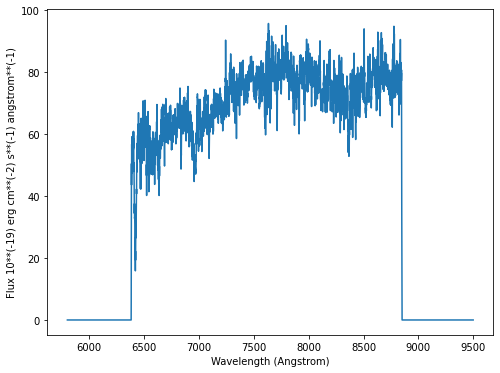

In [8]:
#Plot up the spectrum (flux vs wavelength)
f, a = plt.subplots(figsize=(8,6))
a.plot(wave[0],flux[0],'-') #Since flux and wave are 2D arrays need to specify the 0-th index
a.set_xlabel('Wavelength (Angstrom)')
a.set_ylabel('Flux %s'%(data0.columns[1].unit))

We can also read in binary tables in FITS format using an astropy convenience function `astropy.Table.read()`. The resulting object however is not a numpy.record, but an astropy Table object that has many of the same properties. One additional property of the Astropy `Table` is the `info()` method.

In [9]:
data1 = Table.read(file[0], format='fits')

In [10]:
#Access columns a similar way
print(data1.colnames)

['WAVE', 'FLUX', 'ERR', 'QUAL']


In [11]:
#But can also get info using info method
print(data1.info())

<Table length=1>
name  dtype   shape              unit            
---- ------- ------- ----------------------------
WAVE float32 (6166,)                     Angstrom
FLUX float32 (6166,) 1e-19 erg / (Angstrom cm2 s)
 ERR float32 (6166,) 1e-19 erg / (Angstrom cm2 s)
QUAL   int16 (6166,)                             
None


In [12]:
#Again a good idea to check the shape of the data we're looking at
wave = data1['WAVE']
flux = data1['FLUX']
print(flux.shape)

(1, 6166)


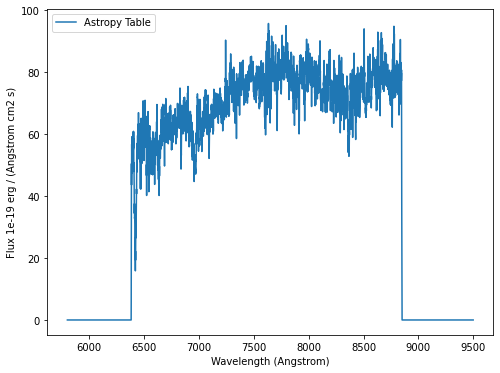

In [13]:
#Plot up the spectrum (flux vs wavelength)
f, a = plt.subplots(figsize=(8,6))
a.plot(wave[0],flux[0],'-',label='Astropy Table') #Since flux and wave are 2D arrays need to specify the 0-th index
a.set_xlabel('Wavelength (Angstrom)')
a.set_ylabel('Flux %s'%(data1.columns[1].unit))
a.legend()

## Reading a Catalog in Binary FITS Table 

FITS binary format is convenient as it allows the storage of lots of data in one file, such as survey catalogs. We can read in a survey catalog, and then use the convenient indexing by column to select specifc objects of interest.

In [14]:
#Read in the LEGA-C catalog fits
cat = './legac_dr2_cat.fits'
cat_tab = Table.read(cat, format='fits')

In [15]:
#Check out what's inside
print(cat_tab.info())

<Table length=1988>
         name          dtype          unit        n_bad
--------------------- ------- ------------------- -----
               OBJECT   int32                         0
             SPECT_ID bytes10                         0
              RAJ2000 float64                 deg     0
             DECJ2000 float64                 deg     0
                    z float32                       144
             Filename bytes26                         0
    SIGMA_STARS_PRIME float32              km / s   146
SIGMA_STARS_PRIME_err float32              km / s   146
      SIGMA_GAS_PRIME float32              km / s   542
  SIGMA_GAS_PRIME_err float32              km / s   542
             LICK_CN1 float32            Angstrom   205
         LICK_CN1_err float32            Angstrom   232
             LICK_CN2 float32            Angstrom   203
         LICK_CN2_err float32            Angstrom   242
          LICK_CA4227 float32            Angstrom   141
      LICK_CA4227_err float3

In the LEGAC DR2 data release paper [here](https://www2.mpia-hd.mpg.de/home/legac/dr2/legac.dr2.pdf) they discuss what's included in the catalog and the meanings of the columns in section 3. Let's focus on their secondary objects that are good spectra with good redshifts, and with S/N of >=20. We'll create a numpy mask for these objects, and then grab the Filenames and coordinates.

In [16]:
secondary = cat_tab['f_primary'] != 1 
good_z = cat_tab['f_z'] == 0
good_sn = cat_tab['SN'] >= 20
good_spec = cat_tab['f_spec'] == 0
mask = np.all([secondary, good_z, good_sn, good_spec], axis=0) #Neat use of np.all to do a logical and across the 4 boolean arrays, ~ is negation
print("%d objects found."%(mask.sum()))

7 objects found.


In [17]:
samp_filenames = cat_tab['Filename'][mask]
samp_ra = cat_tab['RAJ2000'][mask]
samp_dec = cat_tab['DECJ2000'][mask]
samp_specid = cat_tab['SPECT_ID'][mask]

In [18]:
print(samp_filenames)
print(samp_ra)
print(samp_dec)
print(samp_specid)

         Filename         
--------------------------
legac_M4_109742_v2.0.fits 
legac_M9_214843_v2.0.fits 
legac_M10_203467_v2.0.fits
legac_M11_255083_v2.0.fits
legac_M11_257594_v2.0.fits
legac_M13_261993_v2.0.fits
legac_M15_88722_v2.0.fits 
     RAJ2000      
       deg        
------------------
150.33006286621094
150.33706665039062
150.40151977539062
149.88575744628906
149.87083435058594
149.79234313964844
 150.4936065673828
     DECJ2000     
       deg        
------------------
2.0703179836273193
 2.575268030166626
 2.790821075439453
2.7081520557403564
 2.743256092071533
2.7999320030212402
2.2388250827789307
 SPECT_ID 
----------
M4_109742 
M9_214843 
M10_203467
M11_255083
M11_257594
M13_261993
M15_88722 


## Grabbing HST Images with Astroquery

Now let's use astroquery to query the [Canadian Astronomy Data Centre (CADC)](https://astroquery.readthedocs.io/en/latest/cadc/cadc.html) for Hubble images. We'll use astropy's convenient SkyCoords module and parts of the CADC astroquery API.

In [19]:
#Create SkyCoord object using Astropy and the first object's coordinates
coords = SkyCoord(ra=samp_ra[0]*u.degree,dec=samp_dec[0]*u.degree)

In [20]:
#We can also specify the size of cutout images we'd like and make use of astropy's unit module again
#Radius of cutout in degrees
radius = 5.5*u.arcsecond
print(radius)

5.5 arcsec


In [21]:
#Create a CADC object and query it using query region (coordinates and cutout around our object) for the HST collection
cadc = Cadc()
result = cadc.query_region(coords,radius=radius,collection='HST')

The result of the query is an astropy Table object so we can use similar operations above to quickly identify images we'd like--namely those that are final products or composite images that have been reduced.

In [22]:
#Select entries above calibration level 2 and for the ACS instrument
result_cal = result[np.logical_and(result['calibrationLevel'] > 2,result['instrument_name'] == 'ACS/WFC')]
#Grabs composite images
result_comp = result_cal[result_cal['typeCode']=='C']

In [23]:
#Shows table in line
result_comp

observationURI,sequenceNumber,metaReadGroups,proposal_keywords,obsID,collection,observationID,algorithm_name,type,intent,metaRelease,proposal_id,proposal_pi,proposal_project,proposal_title,target_name,target_targetID,target_standard,target_redshift,target_moving,target_keywords,targetPosition_equinox,targetPosition_coordinates_cval1,targetPosition_coordinates_cval2,telescope_geoLocationX,telescope_geoLocationY,target_type,targetPosition_coordsys,telescope_name,telescope_geoLocationZ,telescope_keywords,instrument_keywords,environment_seeing,environment_humidity,environment_elevation,environment_tau,environment_wavelengthTau,environment_ambientTemp,environment_photometric,requirements_flag,instrument_name,members,typeCode,metaProducer,metaChecksum,accMetaChecksum,lastModified,maxLastModified,planeURI,publisherID,obsID2,planeID,productID,metaRelease2,metaReadGroups2,dataReadGroups,calibrationLevel,dataRelease,dataProductType,provenance_name,provenance_version,provenance_reference,provenance_producer,provenance_project,provenance_runID,provenance_keywords,provenance_inputs,provenance_lastExecuted,metrics_sourceNumberDensity,metrics_background,metrics_backgroundStddev,metrics_fluxDensityLimit,metrics_magLimit,position_bounds,position_bounds_samples,position_bounds_size,position_resolution,position_sampleSize,position_dimension_naxis1,position_dimension_naxis2,position_timeDependent,quality_flag,position_resolutionBounds [2],energy_bounds_samples,energy_bounds_lower,energy_bounds_upper,energy_bounds_width,energy_dimension,energy_resolvingPower,energy_sampleSize,energy_bounds [2],energy_resolvingPowerBounds [2],energy_emBand,energy_freqWidth,energy_freqSampleSize,energy_restwav,time_bounds_samples,time_bounds_lower,time_bounds_upper,time_bounds_width,time_dimension,time_resolution,time_sampleSize,energy_energyBands,time_exposure,energy_bandpassName,polarization_dimension,energy_transition_species,energy_transition_transition,time_bounds [2],time_resolutionBounds [2],polarization_states,custom_ctype,custom_bounds_samples,custom_bounds_lower,custom_bounds_upper,custom_bounds_width,custom_dimension,metaProducer2,custom_bounds [2],lastModified2,maxLastModified2,metaChecksum2,accMetaChecksum2
,,,,,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,arcsec,,deg,,m,C,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1 / deg2,Jy / pix,Jy / pix,Jy,,deg,deg,deg,arcsec,arcsec,,,,,arcsec,m,m,m,m,,,m,m,,,Hz,Hz,m,d,d,d,d,,d,d,,s,,,,,d,d,,,,,,,,,,,,,
object,int32,object,object,bytes36,bytes32,bytes128,bytes32,bytes32,bytes32,bytes23,bytes128,bytes128,bytes32,bytes256,bytes32,bytes32,int32,float64,int32,object,float64,float64,float64,float64,float64,bytes32,bytes16,bytes32,float64,object,object,float64,float64,float64,float64,float64,float64,int32,bytes16,bytes32,object,bytes1,object,object,object,bytes23,bytes23,object,object,bytes36,bytes36,bytes64,bytes23,object,object,int32,bytes23,bytes128,bytes128,bytes32,bytes256,bytes128,bytes256,bytes64,object,object,bytes23,float64,float64,float64,float64,float64,object,object,float64,float64,float64,int64,int64,int32,bytes16,float64,object,float64,float64,float64,int64,float64,float64,float64,float64,bytes32,float64,float64,float64,object,float64,float64,float64,int64,float64,float64,bytes32,float64,bytes32,int64,bytes32,bytes32,float64,float64,bytes32,bytes32,object,float64,float64,float64,int64,object,float64,bytes23,bytes23,object,object
caom:HST/jcor23010,--,,,00000000-0000-0000-a8a0-e0c7cc711cf4,HST,jcor23010,drizzle,IMAGING,science,2015-05-09T05:42:59.000,13657,"Kartaltepe, Jeyhan",GO,Probing the Most Luminous Galaxies in the Universe at the Peak of Galaxy Assembly,ANY,,0,--,0,BROAD_CATEGORY=UNIDENTIFIED|TARGET_DESCRIP=UNIDENTIFIED;PARALLEL FIELD,2000.0,150.354669638,2.084289538275,--,--,field,ICRS,HST,--,DEC_V1=1.994299596841|FGSLOCK=FINE|FOV_CONFIG=SM-4|GYROMODE=True|MTFLAG=False|POSTARG1=0.0|POSTARG2=0.0|RA_V1=150.3949387481|V3_PA=288.222198,APERTURE=WFC|DETECTOR=WFC|EXPEND=57151.2381841088|EXPSTART=57151.17282457176|EXPTIME=2146.0|FI

We can now using the results of the query and the `get_image_list` to get list of images for results.

In [24]:
image_list = cadc.get_image_list(result_comp,coordinates=coords,radius=radius)

Next we define a function to use astroquery's API to actually download and save the HDULists for the images in the image_list.

In [25]:
def get_images_from_list(image_list, show_progress=False):
    """Returns lists of HDUs from given image list URLS"""
    from astroquery.utils import commons
    fits_list = []
    fn = [commons.FileContainer(url, encoding='binary',show_progress=show_progress) for url in image_list]
    for f in fn:
        try:
            fits_list.append(f.get_fits())
        except:
            pass
    return fits_list

In [26]:
#Grab fits images
fits_list = get_images_from_list(image_list)

With the list of  HDULists we can now go through and plot the images we found of our object. I defined this plotting function to plot images from our fits_list.

In [27]:
def plot_fits(fits):
    """Returns plot of cutout"""
    from matplotlib import cm, colors
    #This conditional helps ignore some returned composite images that have nans
    if np.isnan(fits['SCI'].data).sum() < 1:
        fig, ax = plt.subplots(figsize=(10,10))
        photname = fits['SCI'].header['PHOTMODE']
        units = fits['SCI'].header['BUNIT']
        im = ax.imshow(fits['SCI'].data)
        cbar = fig.colorbar(im)
        ax.set_title(photname)
        cbar.set_label(units)
    else:
        pass

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ffb1a5537c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ffb1a5734f0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ffb1bbd0670>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7ffb1bbd0f70>]


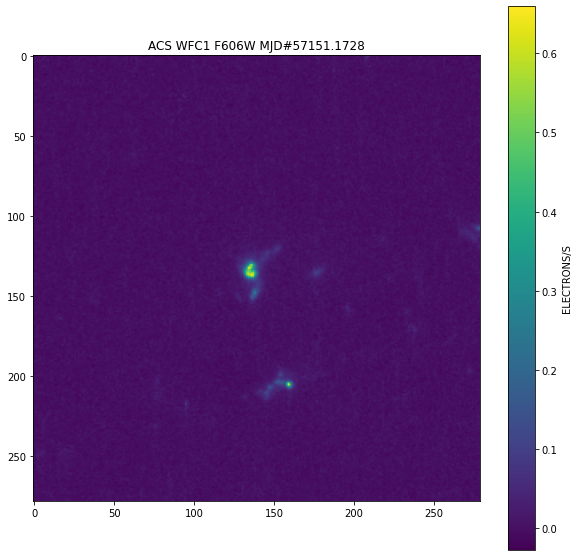

In [31]:
#Plot images
for f in fits_list:
    print(f)
    plot_fits(f)

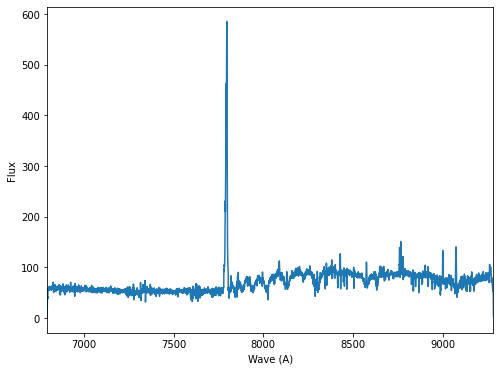

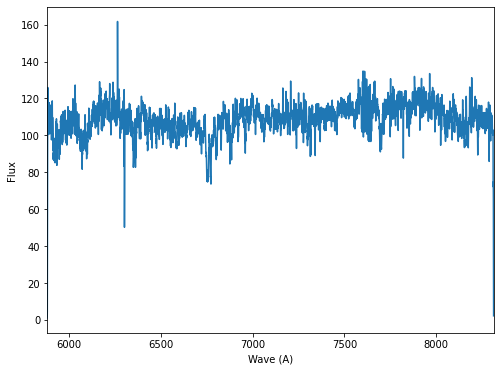

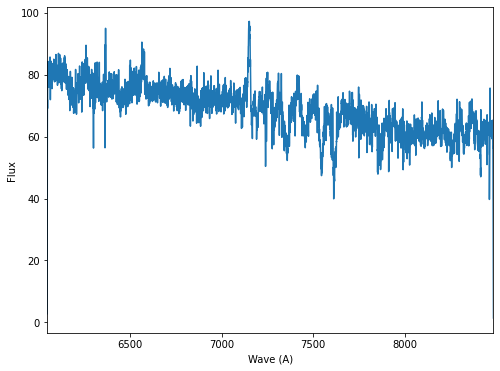

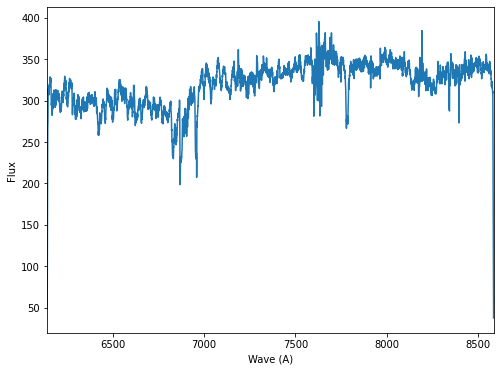

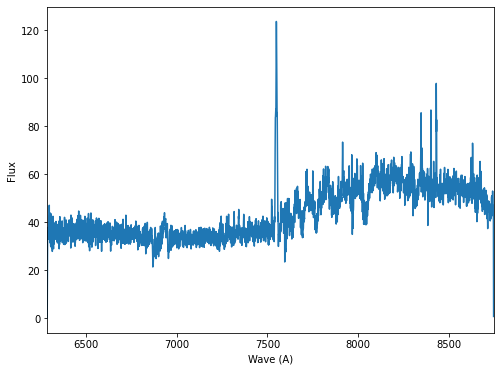

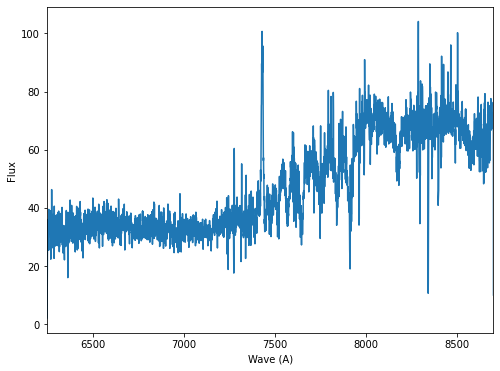

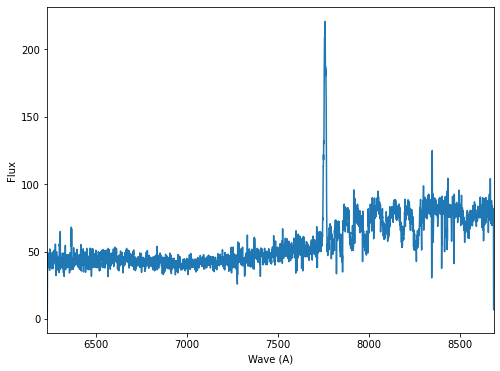

In [29]:
#If we want we can take a look at the spectrum of this object using code above and our filenames

for file in samp_filenames:
    obj0 = fits.open('./spectraDR/'+file.strip())
    wave = obj0[1].data['WAVE'][0]
    flux = obj0[1].data['FLUX'][0]
    
    #Masking to plot only nonzero values of flux (to just look at the interesting parts of the spectra)
    flux_cutoff = np.where(flux != 0)
    flux = flux[flux_cutoff]
    #Plot wave only where flux != 0
    wave = wave[flux_cutoff]

    spec_name = file.split('.fits')[0]
        
    f, a = plt.subplots(figsize=(8,6))
    a.plot(wave, flux,'-')
    a.set_xlabel('Wave (A)')
    a.set_ylabel('Flux')
    a.set_xlim(wave[0],wave[-1]) # set lims to fit plot to figure 


## Things to try

1. The sample size with all those restriction was pretty small. Try removing the requirment that the spectrum be good by removing that boolean mask.
2. Collect the redshift data of the new sample as well.
3. Plot up in a single figure or across multiple figures/pages (PdfPages module) the object specrta next to 1 object image. Include the object title and redshift

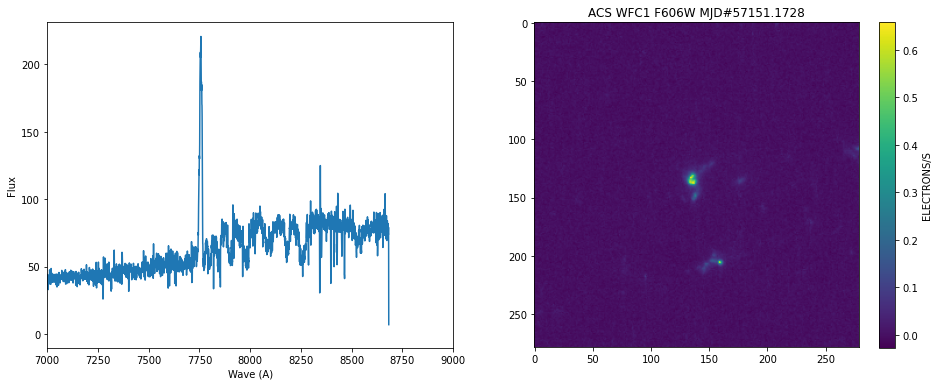

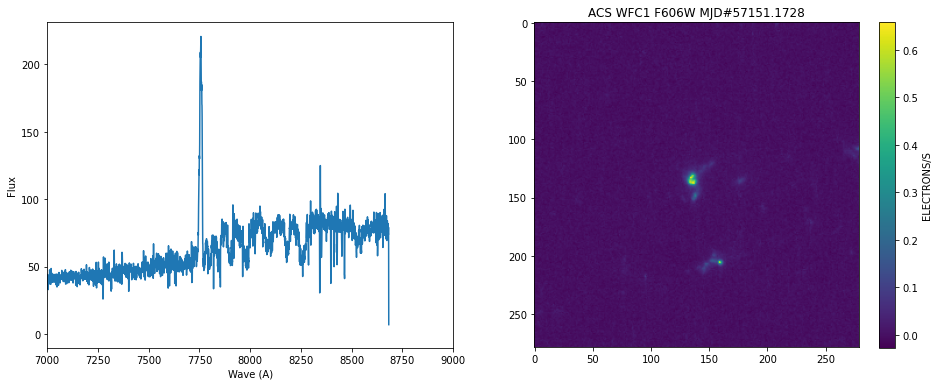

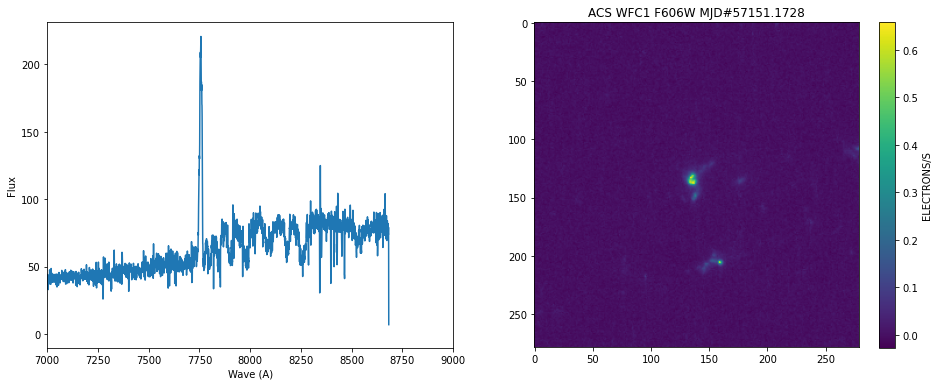

In [34]:
#The basics of PdfPages
from matplotlib.backends.backend_pdf import PdfPages
#Create pdf object
pp = PdfPages('multipage_test.pdf')
#Plot figures
for i in range(3):
    f, a = plt.subplots(1,2,figsize=(8*2,6))
    a[0].plot(wave, flux,'-')
    a[0].set_xlabel('Wave (A)')
    a[0].set_ylabel('Flux')
    a[0].set_xlim(7000,9000)
    photname = fits_list[0]['SCI'].header['PHOTMODE']
    units = fits_list[0]['SCI'].header['BUNIT']
    im = a[1].imshow(fits_list[0]['SCI'].data)
    cbar = f.colorbar(im)
    a[1].set_title(photname)
    cbar.set_label(units)
    #This line saves the previous figure to a page here (you get 3 pages of the same plot in this case)
    pp.savefig()
#Close pdf object writing the pdf
pp.close()